In [8]:
import pathlib
import datetime
import warnings
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
import pickle as plk

import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline  

import pwlf
import sklearn
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV
from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import mean_squared_error
import sklearn.pipeline

In [9]:
# Mimic drop down
building_dropdown = 'CD Howe'
year_dropdown = 2019

In [10]:
# Import Data
PATH = pathlib.Path().parent.parent
DATA_PATH = PATH.joinpath("../app/data").resolve()

with open(DATA_PATH.joinpath(f'{building_dropdown}/Energy/_energyData.pkl'), 'rb') as f:
    energy_df = plk.load(f)

with open(DATA_PATH.joinpath(f'Supporting/Weather/Ottawa.pkl'), 'rb') as f:
    weather_df = plk.load(f)
                          
with open(DATA_PATH.joinpath(f'Supporting/Weather/Ottawa_TMY.pkl'), 'rb') as f:
    weather_TMY = plk.load(f)
                          
    
df_all = pd.merge(energy_df, weather_df, how='outer', left_index=True, right_index=True)
df_all = df_all[df_all.index < datetime.datetime(2020, 10, 1, 0, 0, 0)]
df = df_all[df_all.index.year == year_dropdown]


In [11]:
def prep_data(df, parameter, drop_zero=True):
    df = df.dropna(subset=['temperature', parameter])
    if drop_zero:
        df = df[df[parameter] != 0]
    
    date = df.index.to_numpy()
    x1 = df.temperature.to_numpy()
    x = pd.DataFrame({'date':date, 'x1':x1})
    y = df.chilledWater.to_numpy()
    return x, y


x, y = prep_data(df, 'chilledWater')

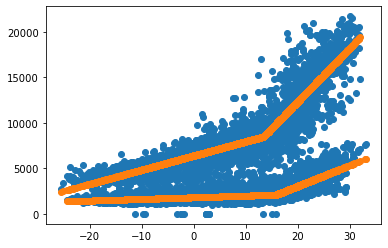

In [12]:
def seperate_data_by_Schedule(d_time, workday_sch, weekend_sch=None):
    
    weekday_on = (d_time.dt.dayofweek < 5) & ((d_time.dt.hour > workday_sch[0]) & (d_time.dt.hour <= workday_sch[1]))
    
    if weekend_sch==None:
        return weekday_on.to_numpy()
    else:
        weekend_on= (d_time.dt.dayofweek >= 5) & ((d_time.dt.hour > weekend_sch[0]) & (d_time.dt.hour <= weekend_sch[1]))
        return (weekday_on | weekend_on).to_numpy()


class pwlf_sch(BaseEstimator, ClassifierMixin):
    """
    """
    def __init__(self, sch=None, weekend_sch=None, line_seg=2):
        '''
        '''
        self.sch = sch
        self.weekend_sch = weekend_sch
        self.line_seg = line_seg
        return None
        
    def fit(self, x, y):
        sch_split = seperate_data_by_Schedule(x.date, self.sch, weekend_sch=self.weekend_sch)
        x_on, y_on = x.x1[sch_split].to_numpy(), y[sch_split]
        x_off, y_off = x.x1[~sch_split].to_numpy(), y[~sch_split]
        
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            self.pwlf_on = pwlf.PiecewiseLinFit(x_on, y_on)
            self.pwlf_on.fit(self.line_seg)
            self.pwlf_off = pwlf.PiecewiseLinFit(x_off, y_off)
            self.pwlf_off.fit(self.line_seg)    
               
        return self
    
    def predict(self, x):
        # Split Schedules
        sch_split = seperate_data_by_Schedule(x.date, self.sch, weekend_sch=self.weekend_sch)               
        
        # Apply Model to appropriate columns
        y_pred = x.x1.copy()     
        y_pred[sch_split] = self.pwlf_on.predict(y_pred[sch_split])
        y_pred[~sch_split] = self.pwlf_off.predict(y_pred[~sch_split])
        y_pred = y_pred.to_numpy()
        
        return y_pred
    
    def score(self, x, y):
        """
        score is reqired so the random search knows what is the best estimator
        """
        y_pred = self.predict(x)
        return mean_squared_error(y, y_pred, squared=False)
    
model = pwlf_sch(sch=[5, 17], weekend_sch=None, line_seg=2)
model.fit(x,y)

plt.scatter(x.x1,y)
plt.scatter(x.x1,model.predict(x))

In [13]:
#Generate Schedule List
search_start, min_sch_len = 4, 7
schs = []
for workDayStart in range(search_start, 24-min_sch_len):
    for workDayEnd in range(workDayStart+min_sch_len, 24):
        schs.append([float(workDayStart), float(workDayEnd)])

weekend_sch = schs.copy()
weekend_sch.append(None)
weekend_sch

c_pt = pwlf_sch(weekend_sch=None, line_seg=2)

grid = {
    'sch': schs
    # 'weekend_sch': weekend_sch
}

gs_dt = GridSearchCV(
    estimator=c_pt, 
    param_grid=grid,
    n_jobs=12, # Based on the number of threads in your cpu core, n=-1 means use all cpu threads
    cv=2, # Cross validation split 
    verbose=1 # Higher means more updates 
).fit(x, y)

Fitting 2 folds for each of 91 candidates, totalling 182 fits


In [15]:
a = pd.DataFrame(gs_dt.cv_results_).sort_values('mean_test_score', ascending=True).reset_index()
a
px.line(a, y='mean_test_score', hover_data=["mean_test_score", "param_sch"])